- _purpose_: Run "Identifying Ground" the "Generating a DTM" sections from the pdal workshop documentation. Test the pipeline on he specific tile (SAN_A02_2014_laz_0.laz) shown in the Kaggle notebook [🛰️Search the Amazon with Remote Sensing and AI🤖](https://www.kaggle.com/code/fnands/search-the-amazon-with-remote-sensing-and-ai) by FNANDS, including some post-processing and "manual" hillshade visualisation.

- _status_: This notebook successfully runs the pdal pipeline on the .laz image: (1) denoises the .laz, (2) processes the .laz to DTM .tif, (3) postprocesses the DTM .tif, (4) performs a hillshade visualisation on the DTM. The raw DTM and the hillshade visualisation look very similar (almost identical) to the ones in the Search the Amazon... Kaggle notebook.

- _next_: Unsure

- _conclusion_: TBD

## PLAD Workshop -> Manipulation -> Identifying ground
link to PDAL workshop documentation: https://pdal.io/en/stable/workshop/manipulation/ground/ground.html

In [56]:
import os
import pandas as pd
import numpy as np
import sys
import time
import math

import io
import base64

import json
import pdal

import rasterio
import matplotlib.pyplot as plt

# compute absolute path to the project root's src/
sys.path.insert(0, os.path.join(os.getcwd(), "src"))

from project_utils import satellite as satellite
from project_utils import lidar as lidar
from project_utils import config as proj_config

# auto-reload any module that changes on disk
%load_ext autoreload
%autoreload
# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
CWD = os.getcwd()
FILENAME = "SAN_A02_2014_laz_0.laz"
PIPELINE_TEMPLATE_DENOISE_NAME = "tutorial_denoise_ground.json"
PIPELINE_TEMPLATE_DTM_NAME = "tutorial_generate_dtm.json"

laz_path = os.path.join(
    CWD,
    "data",
    "raw",
    "tiles",
    "laz",
    FILENAME
)

dtm_path = os.path.join(
    CWD,
    "data",
    "processed",
    "dtm",
    os.path.splitext(FILENAME)[0] +
    "_" +
    os.path.splitext(PIPELINE_TEMPLATE_DENOISE_NAME)[0] +
    ".tif"
)

denoised_laz_path = os.path.join(
    CWD,
    "data",
    "processed",
    "denoised",
    os.path.splitext(FILENAME)[0] +
    "_" +
    os.path.splitext(PIPELINE_TEMPLATE_DENOISE_NAME)[0] +
    ".copc.laz"
)

os.makedirs(os.path.join(
    CWD,
    "data",
    "processed",
    "denoised"
    ), exist_ok=True
)

pipeline_path_denoise = os.path.join(
    CWD,
    "config",
    "pdal_pipelines",
    PIPELINE_TEMPLATE_DTM_NAME +
    ".tif"
)

pipeline_path_dtm = os.path.join(
    CWD,
    "config",
    "pdal_pipelines",
    PIPELINE_TEMPLATE_DTM_NAME
)


print(laz_path)   
print(dtm_path)
print(pipeline_path_denoise)
print(denoised_laz_path)

for path in [laz_path, dtm_path, pipeline_path_denoise, denoised_laz_path]:
    print(os.path.exists(path))

/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/tiles/laz/SAN_A02_2014_laz_0.laz
/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/dtm/SAN_A02_2014_laz_0_tutorial_denoise_ground.tif
/Users/jamesbyers/code/github/Kaggle/openai_to_z/config/pdal_pipelines/tutorial_generate_dtm.json.tif
/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/denoised/SAN_A02_2014_laz_0_tutorial_denoise_ground.copc.laz
True
True
False
True


In [12]:
def pt(msg=None):
    current_time = time.strftime("%H:%M:%S")
    if msg:
        print(f"{current_time}: {msg}")
    else:
        print(current_time)

In [13]:
def minimal_laz_to_denoised(in_laz_path, out_laz_path, pipeline_template_path, verbose=0):
    pt("Checking input files")
    # Check input files
    if not os.path.isfile(in_laz_path):
        raise FileNotFoundError(f"Input .laz file not found: {in_laz_path}")
    if not os.path.isfile(pipeline_template_path):
        raise FileNotFoundError(f"Pipeline template not found: {pipeline_template_path}")
    
    pt("Reading PDAL pipelinetemplate")
    # Read and substitute template
    with open(pipeline_template_path, 'r', encoding='utf-8') as f:
        tpl = f.read()
    pt(f"Template:\n {tpl}")
    
    pt("Filling in pipeline template with in_laz and out_laz")
    pipeline_filled = tpl.format(in_laz=in_laz_path, out_laz=out_laz_path)
    pt(f"Filled in pipeline definition:\n{pipeline_filled}")
    try:
        pipeline_obj = json.loads(pipeline_filled)
        pt("Pipeline is valid JSON after subsitution")
    except Exception as e:
        raise ValueError(f"Pipeline is not valid JSON after substitution: {e}")
    

    # Accept dict with "pipeline" or direct list
    if isinstance(pipeline_obj, dict) and "pipeline" in pipeline_obj:
        pdal_pipe = pipeline_obj["pipeline"]
    elif isinstance(pipeline_obj, list):
        pdal_pipe = pipeline_obj
    else:
        raise ValueError("Pipeline template must be a list or a dict with a 'pipeline' key.")
    
    pt("Running PDAL pipeline")
    # Run PDAL pipeline
    pipe = pdal.Pipeline(json.dumps(pdal_pipe))
    count = pipe.execute()
    if verbose:
        print(f"Processed {count} points to {out_laz_path}")

    # Check output
    if not os.path.isfile(out_laz_path):
        raise RuntimeError(f"Output file not created: {out_laz_path}")
    return out_laz_path

In [ ]:
denoised_laz_path = minimal_laz_to_denoised(laz_path, denoised_laz_path, pipeline_path_denoise)

15:18:12: Checking input files
15:18:12: Reading PDAL pipelinetemplate
15:18:12: Template:
 {{
    "pipeline": [
      {{
        "type": "readers.las",
        "filename": "{in_laz}"
      }},
      {{
        "type": "filters.outlier",
        "method": "statistical",
        "mean_k": 8,
        "multiplier": 3.0
      }},
      {{
        "type": "filters.smrf",
        "ignore": "Classification[7:7]"
      }},
      {{
        "type": "filters.expression",
        "expression": "Classification == 2"
      }},
      {{
        "type": "writers.copc",
        "filename": "{out_laz}"
      }}
    ]
  }}
15:18:12: Filling in pipeline template with in_laz and out_laz
15:18:12: Filled in pipeline definition:
{
    "pipeline": [
      {
        "type": "readers.las",
        "filename": "/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/tiles/laz/SAN_A02_2014_laz_0.laz"
      },
      {
        "type": "filters.outlier",
        "method": "statistical",
        "mean_k": 8,
     

## PLAD Workshop -> Generation -> Generating a DTM
link to PDAL workshop documentation: https://pdal.io/en/stable/workshop/generation/dtm/dtm.html

At the start of this section of the notebook we should have a "denoised ground only" .laz file, which in this case is

In [14]:
print(f"Denoised laz path: {denoised_laz_path}")
os.path.exists(denoised_laz_path)

Denoised laz path: /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/denoised/SAN_A02_2014_laz_0_tutorial_denoise_ground.copc.laz


True

In [15]:
def denoised_to_dtm(in_laz_path, out_dtm_path, pipeline_template_path, verbose=0):
    pt("Checking input files")
    # Check input files
    if not os.path.isfile(in_laz_path):
        raise FileNotFoundError(f"Input .laz file not found: {in_laz_path}")
    if not os.path.isfile(pipeline_template_path):
        raise FileNotFoundError(f"Pipeline template not found: {pipeline_template_path}")
    
    pt("Reading PDAL pipelinetemplate")
    # Read and substitute template
    with open(pipeline_template_path, 'r', encoding='utf-8') as f:
        tpl = f.read()
    pt(f"Template:\n {tpl}")
    
    pt("Filling in pipeline template with in_laz and out_laz")
    pipeline_filled = tpl.format(in_laz=in_laz_path, out_tif=out_dtm_path)
    pt(f"Filled in pipeline definition:\n{pipeline_filled}")
    try:
        pipeline_obj = json.loads(pipeline_filled)
        pt("Pipeline is valid JSON after subsitution")
    except Exception as e:
        raise ValueError(f"Pipeline is not valid JSON after substitution: {e}")
    

    # Accept dict with "pipeline" or direct list
    if isinstance(pipeline_obj, dict) and "pipeline" in pipeline_obj:
        pdal_pipe = pipeline_obj["pipeline"]
    elif isinstance(pipeline_obj, list):
        pdal_pipe = pipeline_obj
    else:
        raise ValueError("Pipeline template must be a list or a dict with a 'pipeline' key.")
    
    pt("Running PDAL pipeline")
    # Run PDAL pipeline
    pipe = pdal.Pipeline(json.dumps(pdal_pipe))
    count = pipe.execute()
    if verbose:
        print(f"Processed {count} points to {out_dtm_path}")

    # Check output
    if not os.path.isfile(out_dtm_path):
        raise RuntimeError(f"Output file not created: {out_dtm_path}")
    return out_dtm_path

In [47]:
out_dtm_path = denoised_to_dtm(laz_path, dtm_path, pipeline_path_dtm)

15:40:23: Checking input files
15:40:23: Reading PDAL pipelinetemplate
15:40:23: Template:
 {{
    "pipeline": [
        {{
            "type": "readers.las",
            "filename": "{in_laz}"
        }},
        {{
            "filename":"{out_tif}",
            "gdaldriver":"GTiff",
            "output_type":"min",
            "resolution":"2.0",
            "type": "writers.gdal"
        }}
    ]
}}
15:40:23: Filling in pipeline template with in_laz and out_laz
15:40:23: Filled in pipeline definition:
{
    "pipeline": [
        {
            "type": "readers.las",
            "filename": "/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/tiles/laz/SAN_A02_2014_laz_0.laz"
        },
        {
            "filename":"/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/dtm/SAN_A02_2014_laz_0_tutorial_denoise_ground.tif",
            "gdaldriver":"GTiff",
            "output_type":"min",
            "resolution":"2.0",
            "type": "writers.gdal"
        }
 

In [53]:
with rasterio.open(out_dtm_path) as src:
    print("Number of bands (layers):", src.count)
    print("Shape (height, width):", src.height, src.width)
    print("CRS:", src.crs)
    print("Data type:", src.dtypes[0])
    print("Bounds:", src.bounds)
    print("Other metadata:", src.meta)

Number of bands (layers): 1
Shape (height, width): 331 312
CRS: None
Data type: float64
Bounds: BoundingBox(left=738000.0, bottom=9636338.08, right=738624.0, top=9637000.08)
Other metadata: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 312, 'height': 331, 'count': 1, 'crs': None, 'transform': Affine(2.0, 0.0, 738000.0,
       0.0, -2.0, 9637000.08)}


In [49]:
nodata_value = -9999  # or np.nan, but use a finite value for GeoTIFFs!

with rasterio.open(out_dtm_path) as src:
    meta = src.meta.copy()
    meta.update(nodata=nodata_value)
    bands = []
    for i in range(1, src.count + 1):
        arr = src.read(i)
        arr_clean = np.where(arr < 0, 100, arr)
        print(np.mean(arr_clean))
        bands.append(arr_clean)
    data = np.stack(bands)

76.88644376016732


In [ ]:
# Taken from https://www.neonscience.org/resources/learning-hub/tutorials/create-hillshade-py
# Hillshade calculation
def hillshade(array, azimuth, angle_altitude):
    azimuth = 360.0 - azimuth
    x, y = np.gradient(array)
    slope = np.pi / 2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azm_rad = azimuth * np.pi / 180.
    alt_rad = angle_altitude * np.pi / 180.
    shaded = np.sin(alt_rad) * np.sin(slope) + np.cos(alt_rad) * np.cos(slope) * np.cos((azm_rad - np.pi/2.) - aspect)
    return 255 * (shaded + 1) / 2

def encode_image(array, cmap='terrain', vmin=None, vmax=None):
    clean_arr = np.nan_to_num(array, nan=-1)
    plt.figure(figsize=(10, 6))
    plt.imshow(clean_arr, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.tight_layout()
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg', bbox_inches='tight', dpi=150)
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode('utf-8')


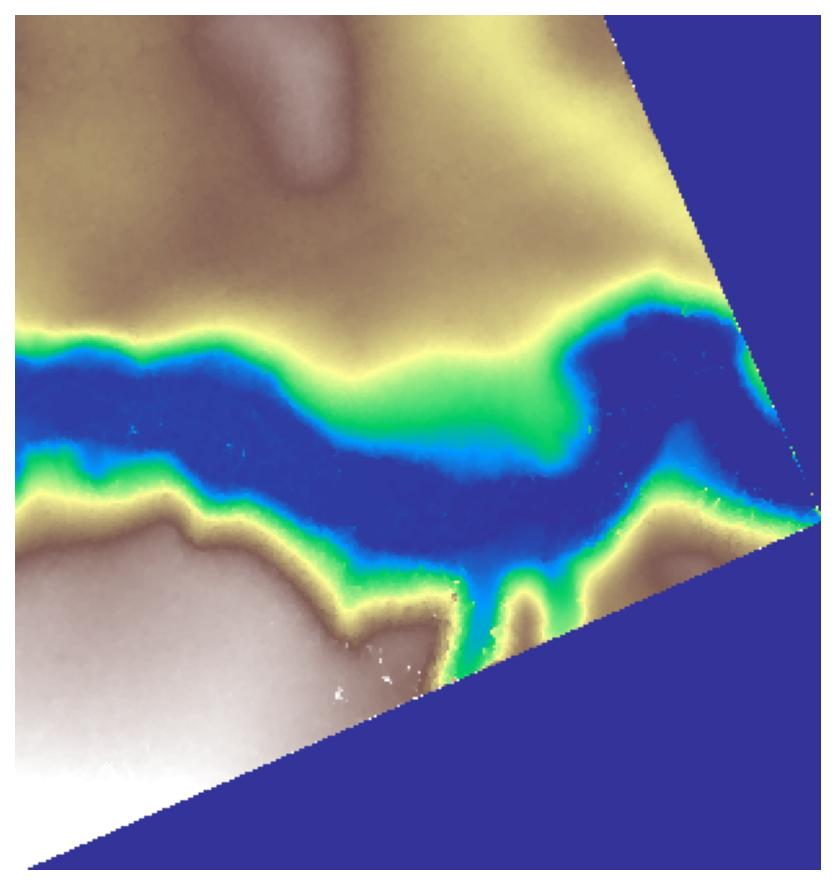
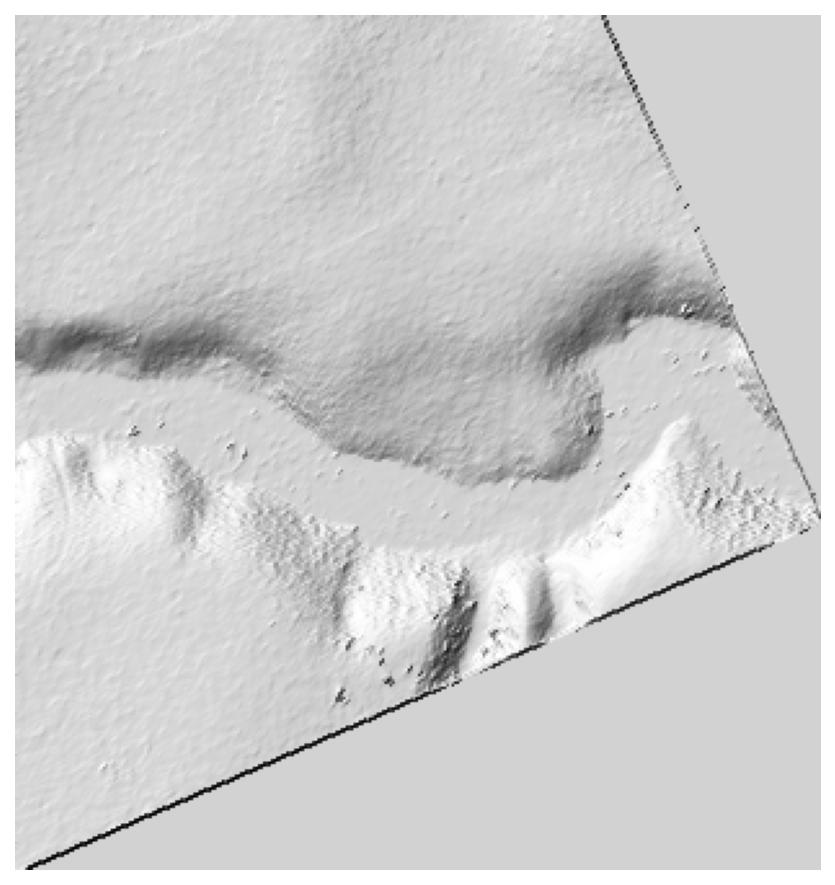

In [68]:
def process_dtm_tile(out_dtm_path):
    with rasterio.open(out_dtm_path) as src:
        dem = src.read(1)
        dem = np.where(dem == src.nodata, np.nan, dem)

        # Normalize DEM for color image
        vmin = np.nanpercentile(dem, 2)
        vmax = np.nanpercentile(dem, 98)

        dem_base64 = encode_image(dem, cmap='terrain', vmin=vmin, vmax=vmax)

        # Generate hillshade from filled DEM
        dem_filled = np.nan_to_num(dem, nan=np.nanmean(dem))
        hs = hillshade(dem_filled, azimuth=315, angle_altitude=45)
        hillshade_base64 = encode_image(hs, cmap='gray')

        return dem_base64, hillshade_base64
    
dem_b64, hillshade_b64 = process_dtm_tile(out_dtm_path)

from IPython.display import HTML
HTML(f"""
<h3>DTM (Terrain Color)</h3>
<img src="data:image/jpeg;base64,{dem_b64}"/>
<h3>Hillshade</h3>
<img src="data:image/jpeg;base64,{hillshade_b64}"/>
""")

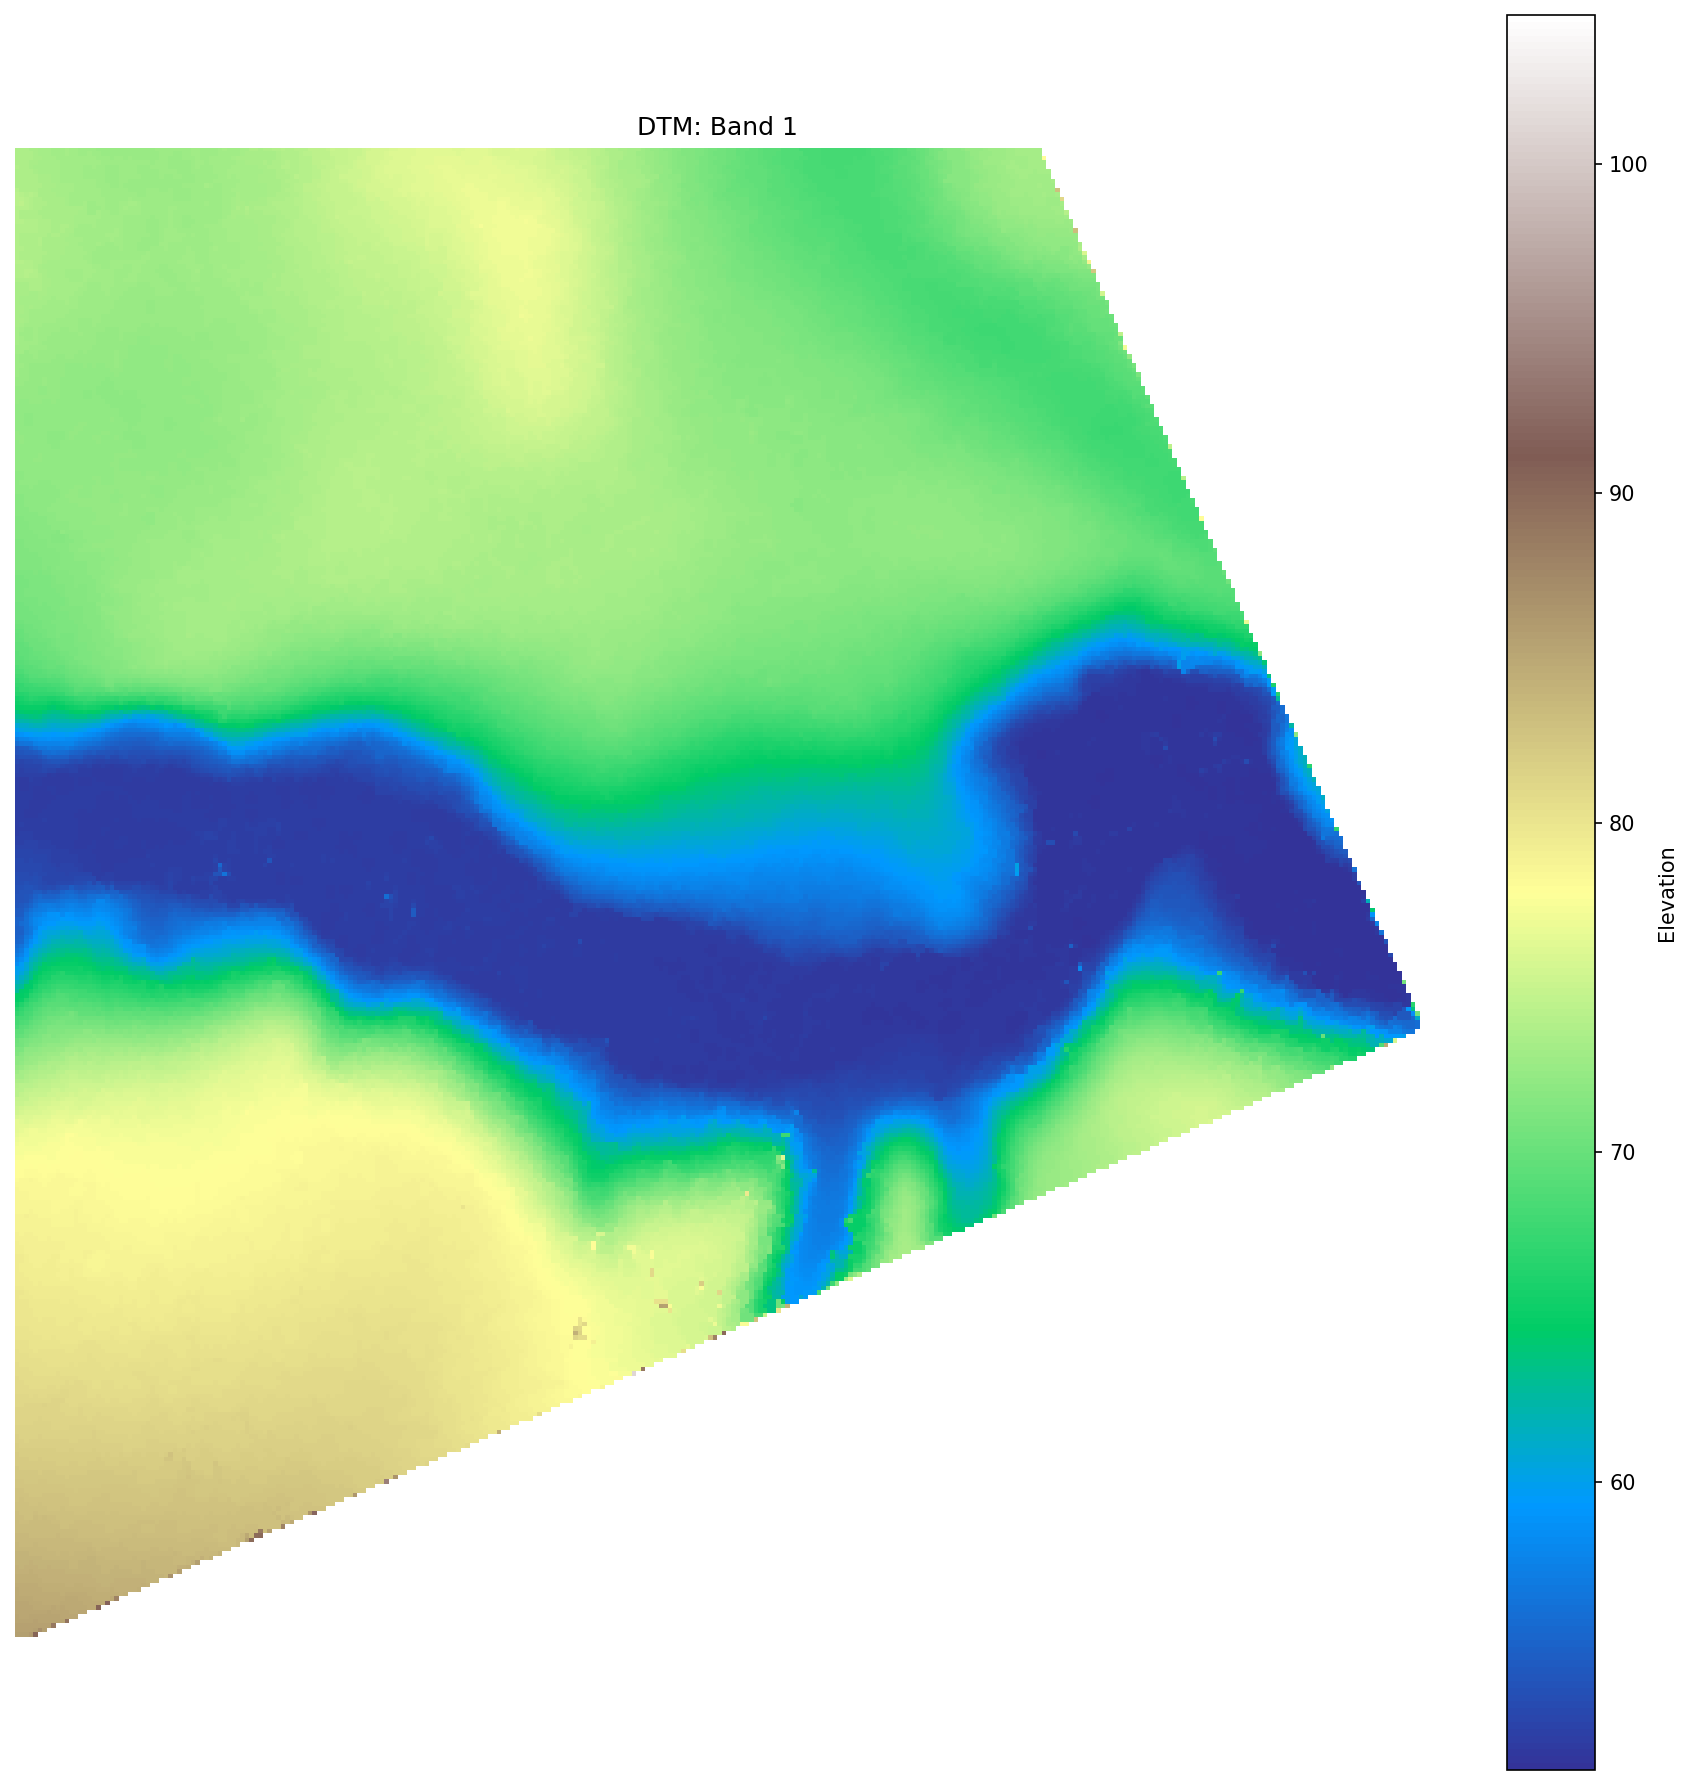

In [67]:
out_image = "my_dtm_highres.png"

with rasterio.open(out_dtm_path) as src:
    band = src.read(1)
    # Mask nodata for visualization
    nodata = src.nodata
    if nodata is not None:
        band = np.where(band == nodata, np.nan, band)
    plt.figure(figsize=(12, 12), dpi=150)  # Make bigger for more apparent detail
    plt.imshow(band, cmap="terrain")
    plt.colorbar(label='Elevation')
    plt.title("DTM: Band 1")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_image, bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
"""
This python script is for calculating VAT Combined blender combination
(1st layer: VAT general (with opacity set in parameters, blend mode normal), 2nd layer: VAT flat)
on multiple DEMs with multiple processes.
Parameters are:
    input_dir_path (dir that contains GeoTIFFs of DEMs)
    output_dir_path (dir where to store calculated GeoTIFFS of VAT combined visualizations)
    general_opacity (opacity of VAT general)
    vat_combination_json_path (path to VAT combination JSON file)
    terrains_sett_json_path (path to terrains settings JSON file)
    nr_processes (number of parallel processes which are calculating and saving output VAT combined)
    save_float (if saves float)
    save_8bit (if saves 8bit)
    save_VAT_general (if saves VAT general)
    save_VAT_flat (if saves VAT flat)
"""
import rvt.vis
import rvt.blend
import rvt.default
import os
import multiprocessing as mp

input_dir_path = out_dtm_path
output_dir_path = CWD
general_opacity = 50
vat_combination_json_path = os.path.join(CWD, "/papers/2023Kokalj/RVT_py/settings/blender_VAT.json")
terrains_sett_json_path = os.path.join(CWD, "apers/2023Kokalj/RVT_py/settings/default_terrains_settings.json")
nr_processes = 2
save_float = True
save_8bit = True
save_VAT_general = True
save_VAT_flat = True


def combined_VAT(input_dir_path, output_dir_path, general_opacity, vat_combination_json_path=None,
                 terrains_sett_json_path=None, nr_processes=7, save_float=True, save_8bit=False,
                 save_VAT_general=False, save_VAT_flat=False):
    if not save_float and not save_8bit:
        raise Exception("save_float and save_8bit are both False!")

    if vat_combination_json_path is None:  # Če ni podan path do vat_comb se smatra da je v settings
        vat_combination_json_path = os.path.abspath(os.path.join("settings", "blender_VAT.json"))

    if terrains_sett_json_path is None:  # Če ni podan path do terrain sett se smatra da je v settings
        terrains_sett_json_path = os.path.abspath(os.path.join("settings",
                                                               "default_terrains_settings.json"))

    # 2 default classes one for VAT general one for VAT flat
    default_1 = rvt.default.DefaultValues()  # VAT general
    default_2 = rvt.default.DefaultValues()  # VAT flat

    # fill no_data and original no data
    default_1.fill_no_data = 0
    default_2.fill_no_data = 0
    default_1.keep_original_no_data = 0
    default_2.keep_original_no_data = 0

    # 2 blender combination classes one for VAT general one for VAT flat
    vat_combination_1 = rvt.blend.BlenderCombination()  # VAT general
    vat_combination_2 = rvt.blend.BlenderCombination()  # VAT flat

    # read combination from JSON
    vat_combination_1.read_from_file(vat_combination_json_path)
    vat_combination_2.read_from_file(vat_combination_json_path)

    # create terrains settings and read it from JSON
    terrains_settings = rvt.blend.TerrainsSettings()
    terrains_settings.read_from_file(terrains_sett_json_path)

    # select single terrain settings for general and flat
    terrain_1 = terrains_settings.select_terrain_settings_by_name("general")  # VAT general
    terrain_2 = terrains_settings.select_terrain_settings_by_name("flat")  # VAT flat

    # apply terrain settings on default and combination
    terrain_1.apply_terrain(default=default_1, combination=vat_combination_1)  # VAT general
    terrain_2.apply_terrain(default=default_2, combination=vat_combination_2)  # VAT flat

    # prepare for multiprocessing
    dem_list = os.listdir(input_dir_path)
    input_process_list = []
    for input_dem_name in dem_list:
        if ".tif" not in input_dem_name:  # preskoči če se file ne konča .tif
            continue
        input_dem_path = os.path.join(input_dir_path, input_dem_name)
        out_name = "{}_Archaeological_(VAT_combined)_opac{}.tif".format(input_dem_name.rstrip(".tif"), general_opacity)
        out_comb_vat_path = os.path.abspath(os.path.join(output_dir_path, out_name))
        out_comb_vat_8bit_path = out_comb_vat_path.rstrip(".tif") + "_8bit.tif"
        if save_8bit and os.path.isfile(out_comb_vat_8bit_path) and save_float and os.path.isfile(out_comb_vat_path):
            print("{} already exists!".format(out_comb_vat_path))
            print("{} already exists!".format(out_comb_vat_8bit_path))
            continue
        elif save_float and os.path.isfile(out_comb_vat_path) and not save_8bit:  # output VAT comb already exists
            print("{} already exists!".format(out_comb_vat_path))
            continue
        elif save_8bit and os.path.isfile(out_comb_vat_8bit_path) and not save_float:
            print("{} already exists!".format(out_comb_vat_8bit_path))
            continue
        general_combination = vat_combination_1
        flat_combination = vat_combination_2
        general_default = default_1
        flat_default = default_2
        out_comb_vat_general_name = "{}_Archaeological_(VAT_general).tif".format(input_dem_name.rstrip(".tif"))
        out_comb_vat_general_path = os.path.abspath(os.path.join(output_dir_path, out_comb_vat_general_name))
        out_comb_vat_flat_name = "{}_Archaeological_(VAT_flat).tif".format(input_dem_name.rstrip(".tif"))
        out_comb_vat_flat_path = os.path.abspath(os.path.join(output_dir_path, out_comb_vat_flat_name))
        input_process_list.append((general_combination, flat_combination, general_default, flat_default,
                                   input_dem_path, out_comb_vat_path,
                                   general_opacity, save_float, save_8bit, save_VAT_general,
                                   out_comb_vat_general_path, save_VAT_flat, out_comb_vat_flat_path))

    # multiprocessing
    with mp.Pool(nr_processes) as p:
        realist = [p.apply_async(compute_save_VAT_combined, r) for r in input_process_list]
        for result in realist:
            print(result.get())


# function which is multiprocessing
def compute_save_VAT_combined(general_combination, flat_combination, general_default, flat_default,
                              input_dem_path, out_comb_vat_path,
                              general_transparency, save_float, save_8bit, save_VAT_general, out_comb_vat_general_path,
                              save_VAT_flat, out_comb_vat_flat_path):
    dict_arr_res_nd = rvt.default.get_raster_arr(raster_path=input_dem_path)

    # create and blend VAT general
    general_combination.add_dem_arr(dem_arr=dict_arr_res_nd["array"],
                                    dem_resolution=dict_arr_res_nd["resolution"][0])
    if save_VAT_general:
        general_combination.add_dem_path(dem_path=input_dem_path)
        vat_arr_1 = general_combination.render_all_images(save_render_path=out_comb_vat_general_path,
                                                          save_float=save_float, save_8bit=save_8bit,
                                                          default=general_default, no_data=dict_arr_res_nd["no_data"])
    else:
        vat_arr_1 = general_combination.render_all_images(default=general_default, no_data=dict_arr_res_nd["no_data"])

    # create and blend VAT flat
    flat_combination.add_dem_arr(dem_arr=dict_arr_res_nd["array"],
                                 dem_resolution=dict_arr_res_nd["resolution"][0])
    if save_VAT_flat:
        flat_combination.add_dem_path(dem_path=input_dem_path)
        vat_arr_2 = flat_combination.render_all_images(save_render_path=out_comb_vat_flat_path,
                                                       save_float=save_float, save_8bit=save_8bit,
                                                       default=flat_default, no_data=dict_arr_res_nd["no_data"])
    else:
        vat_arr_2 = flat_combination.render_all_images(default=flat_default, no_data=dict_arr_res_nd["no_data"])

    # create combination which blends VAT flat and VAT general together
    combination = rvt.blend.BlenderCombination()
    combination.create_layer(vis_method="VAT general", image=vat_arr_1, normalization="Value", minimum=0,
                             maximum=1, blend_mode="Normal", opacity=general_transparency)
    combination.create_layer(vis_method="VAT flat", image=vat_arr_2, normalization="Value", minimum=0,
                             maximum=1, blend_mode="Normal", opacity=100)

    combination.add_dem_path(dem_path=input_dem_path)

    # VAT combined
    combination.render_all_images(save_render_path=out_comb_vat_path, save_visualizations=False,
                                  save_float=save_float, save_8bit=save_8bit,
                                  no_data=dict_arr_res_nd["no_data"])
    out_comb_vat_8bit_path = out_comb_vat_path.rstrip("tif") + "_8bit.tif"
    if save_float and save_8bit:
        return "{} and {} successfully calculated and saved!".format(out_comb_vat_path, out_comb_vat_8bit_path)
    elif save_float:
        return "{} successfully calculated and saved!".format(out_comb_vat_path)
    elif save_8bit:
        return "{} successfully calculated and saved!".format(out_comb_vat_8bit_path)


# Program start
combined_VAT(input_dir_path=input_dir_path, output_dir_path=output_dir_path,
                general_opacity=general_opacity, vat_combination_json_path=vat_combination_json_path,
                terrains_sett_json_path=terrains_sett_json_path, nr_processes=nr_processes, save_float=save_float,
                save_8bit=save_8bit, save_VAT_general=save_VAT_general, save_VAT_flat=save_VAT_flat)